In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [col for col in numeric_cols if not col.lower() in ['id', 'index', 'movieid', 'movie_id']]
    print(f"Dataset cargado: {file_path} | {df.shape[0]} filas, {len(feature_cols)} columnas numéricas.")
    return df, feature_cols

print("CARGANDO ARCHIVOS...")
df_pca, features_pca = load_data('movies_pca_features.csv')
df_umap, features_umap = load_data('movies_umap.csv')

CARGANDO ARCHIVOS...
Dataset cargado: movies_pca_features.csv | 5831 filas, 90 columnas numéricas.
Dataset cargado: movies_umap.csv | 5831 filas, 50 columnas numéricas.


In [3]:
df_combined = pd.read_parquet("movies_combined_features.parquet")
print(f"\nCombined cargado: {df_combined.shape} columnas = {list(df_combined.columns)}")


Combined cargado: (5831, 3) columnas = ['movieId', 'title', 'features']


In [4]:
X_combined = np.vstack(df_combined['features'].values)
feature_cols_combined = [f"feature_{i+1}" for i in range(X_combined.shape[1])]
df_combined_expanded = pd.DataFrame(X_combined, columns=feature_cols_combined)
df_combined_expanded['movieId'] = df_combined['movieId']
df_combined_expanded['title'] = df_combined['title']
print(f"Combined expandido: {df_combined_expanded.shape}")

Combined expandido: (5831, 307)


In [5]:
def initialize_centroids_plus_plus(X, k):
    n_samples = X.shape[0]
    centroids = [X[np.random.randint(n_samples)]]
    for _ in range(k - 1):
        distances = np.array([min([np.inner(c-x, c-x) for c in centroids]) for x in X])
        probs = distances / distances.sum()
        cumulative_probs = probs.cumsum()
        r = np.random.rand()
        for j, p in enumerate(cumulative_probs):
            if r < p:
                centroids.append(X[j])
                break
    return np.array(centroids)

def kmeans_from_scratch(X, k=5, max_iters=100, random_state=42):
    np.random.seed(random_state)
    n_samples, n_features = X.shape
    centroids = initialize_centroids_plus_plus(X, k)
    labels = np.zeros(n_samples)
    for iteration in range(max_iters):
        old_centroids = centroids.copy()
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)
        for i in range(k):
            if np.sum(labels == i) > 0:
                centroids[i] = X[labels == i].mean(axis=0)
        if np.allclose(old_centroids, centroids):
            break
    inertia = sum(np.sum((X[labels == i] - centroids[i])**2) for i in range(k))
    return centroids, labels, iteration + 1, inertia

In [ ]:
def elbow_method(X, max_k=15, method='sklearn'):
    inertias, silhouette_scores = [], []
    k_range = range(2, max_k + 1)
    print(f"\nCalculando métricas para k=2 hasta k={max_k}...")
    for k in k_range:
        if method == 'sklearn':
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X)
            inertia = kmeans.inertia_
        else:
            _, labels, _, inertia = kmeans_from_scratch(X, k=k)
        inertias.append(inertia)
        if len(X) < 10000:
            silhouette_scores.append(silhouette_score(X, labels))
        if k % 3 == 0:
            msg = f"k={k}: Inercia={inertia:.2f}"
            if len(X) < 10000:
                msg += f", Silhouette={silhouette_scores[-1]:.3f}"
            print(msg)
    # Graficar
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].set_title('Método del Codo', fontsize=14, fontweight='bold')
    axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    axes[1].set_title('Método Silhouette', fontsize=14, fontweight='bold')
    plt.show()
    return inertias, silhouette_scores if len(X) < 10000 else None

def evaluate_clustering(X, labels, k):
    print(f"\nEVALUACIÓN DEL CLUSTERING (k={k})\n")
    silhouette = silhouette_score(X, labels) if len(X) < 10000 else None
    db_index = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    if silhouette is not None:
        print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {db_index:.4f}")
    print(f"Calinski-Harabasz Score: {ch_score:.4f}")
    print("\nDistribución de películas por cluster:")
    unique, counts = np.unique(labels, return_counts=True)
    for c, count in zip(unique, counts):
        print(f"  Cluster {c}: {count} películas ({100*count/len(labels):.1f}%)")
    return {'silhouette': silhouette, 'davies_bouldin': db_index, 'calinski_harabasz': ch_score}

def visualize_clusters_2d(X, labels, centroids=None, title="Clustering Results"):
    plt.figure(figsize=(12, 8))
    X_2d = X[:, :2] if X.shape[1] >= 2 else X
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis', alpha=0.6, s=50)
    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, edgecolors='black', linewidths=2)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.colorbar(scatter, label='Cluster ID')
    plt.show()

In [ ]:
def run_kmeans_analysis(df, feature_cols, dataset_name, optimal_k=None):
    print(f"\nANÁLISIS K-MEANS: {dataset_name}\n")
    X = df[feature_cols].values
    X_scaled = StandardScaler().fit_transform(X)
    print(f"Datos preparados: {X_scaled.shape}")


    if optimal_k is None:
        inertias, silhouettes = elbow_method(X_scaled, max_k=15)
        optimal_k = np.argmax(silhouettes) + 2 if silhouettes is not None else 5
        print(f"\nK sugerido por Silhouette: {optimal_k}")


    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    metrics = evaluate_clustering(X_scaled, labels, optimal_k)
    visualize_clusters_2d(X_scaled, labels, kmeans.cluster_centers_, f"{dataset_name} (k={optimal_k})")

    df_result = df.copy()
    df_result['cluster'] = labels
    output_file = f"{dataset_name.lower().replace(' ', '_')}_clustered.csv"
    df_result.to_csv(output_file, index=False)
    print(f"Resultados guardados en: {output_file}")
    return {'k': optimal_k, 'metrics': metrics}


############################################################
ANÁLISIS K-MEANS: PCA Features
############################################################
Datos preparados: (5831, 90)

Calculando métricas para k=2 hasta k=15...
k=3: Inercia=515214.04, Silhouette=0.025
k=6: Inercia=503996.57, Silhouette=-0.046
k=9: Inercia=493345.11, Silhouette=-0.058
k=12: Inercia=483632.82, Silhouette=-0.054
k=15: Inercia=474213.48, Silhouette=-0.061


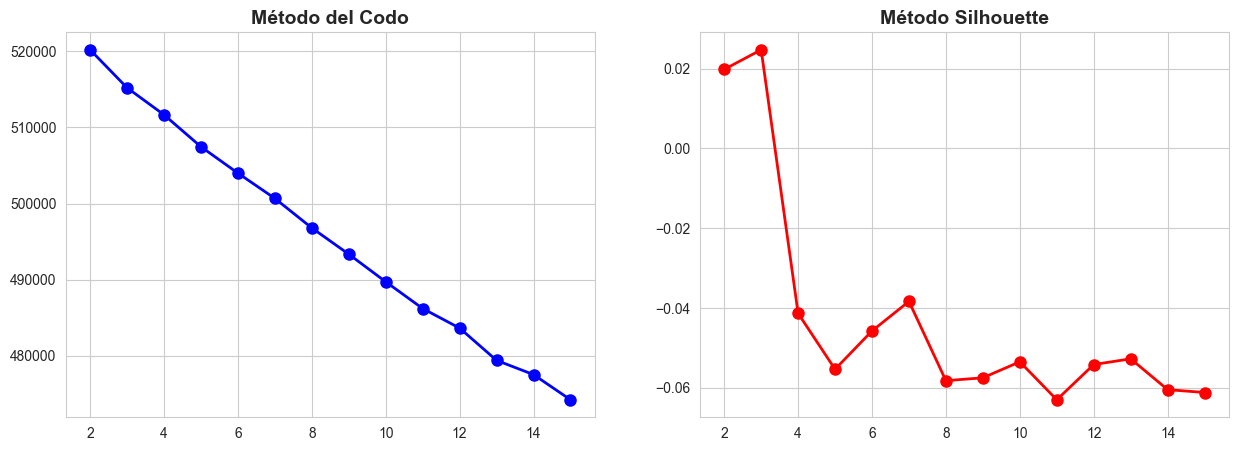


K sugerido por Silhouette: 3

EVALUACIÓN DEL CLUSTERING (k=3)
Silhouette Score: 0.0247
Davies-Bouldin Index: 6.0533
Calinski-Harabasz Score: 54.1607

Distribución de películas por cluster:
  Cluster 0: 379 películas (6.5%)
  Cluster 1: 908 películas (15.6%)
  Cluster 2: 4544 películas (77.9%)


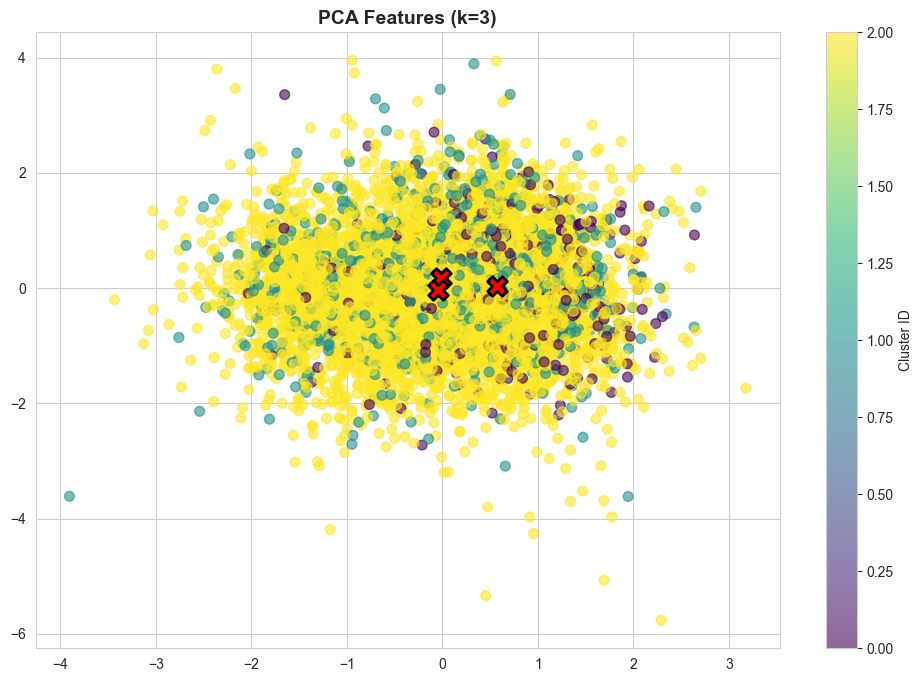

Resultados guardados en: pca_features_clustered.csv

############################################################
ANÁLISIS K-MEANS: UMAP Features
############################################################
Datos preparados: (5831, 50)

Calculando métricas para k=2 hasta k=15...
k=3: Inercia=137049.89, Silhouette=0.338
k=6: Inercia=87712.05, Silhouette=0.301
k=9: Inercia=67823.32, Silhouette=0.279
k=12: Inercia=56606.87, Silhouette=0.252
k=15: Inercia=48299.12, Silhouette=0.262


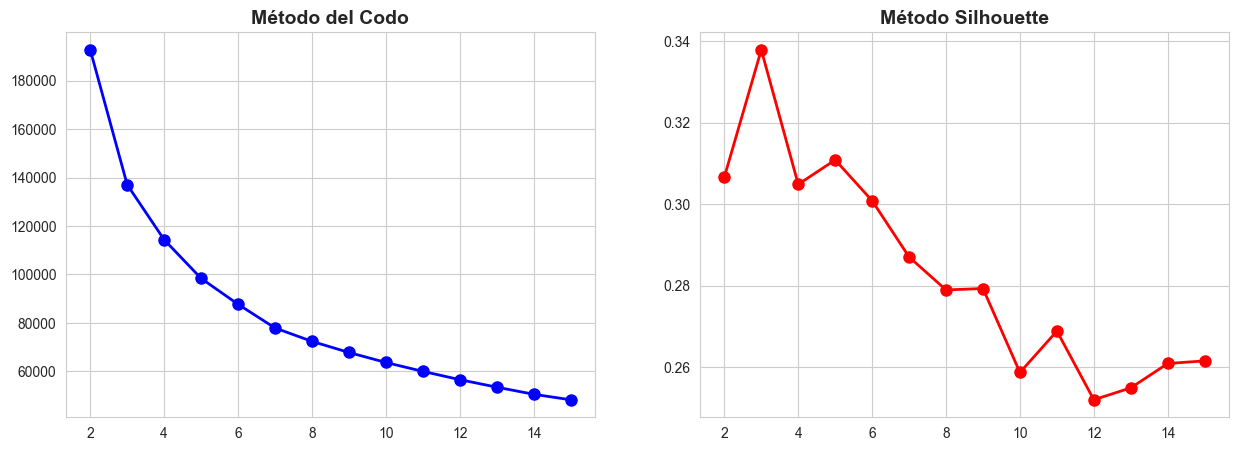


K sugerido por Silhouette: 3

EVALUACIÓN DEL CLUSTERING (k=3)
Silhouette Score: 0.3379
Davies-Bouldin Index: 1.0565
Calinski-Harabasz Score: 3285.0335

Distribución de películas por cluster:
  Cluster 0: 1290 películas (22.1%)
  Cluster 1: 2525 películas (43.3%)
  Cluster 2: 2016 películas (34.6%)


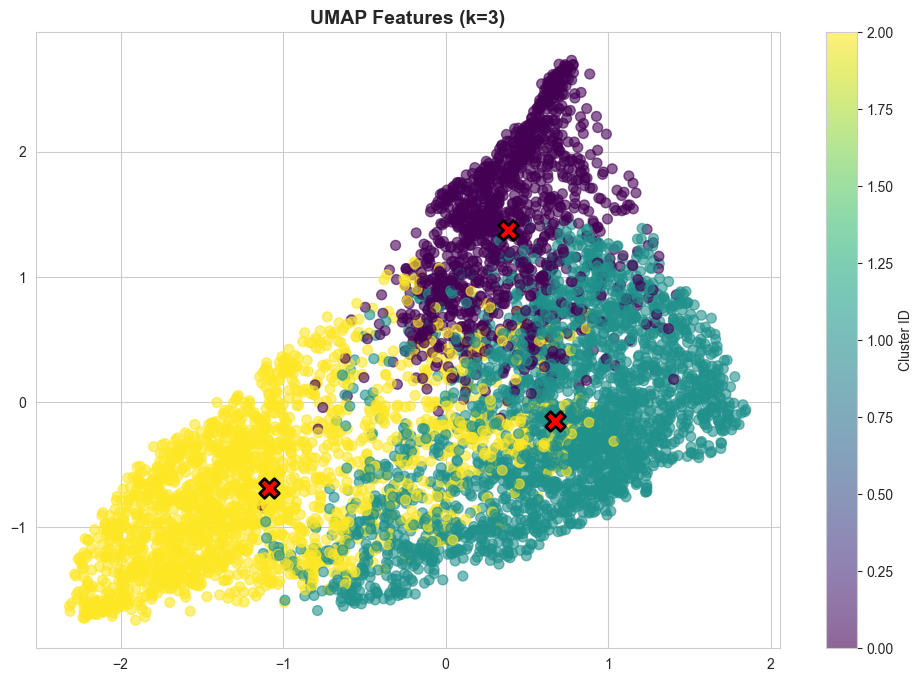

Resultados guardados en: umap_features_clustered.csv

############################################################
ANÁLISIS K-MEANS: Combined Features
############################################################
Datos preparados: (5831, 305)

Calculando métricas para k=2 hasta k=15...
k=3: Inercia=1475702.62, Silhouette=0.102
k=6: Inercia=1337475.50, Silhouette=0.074
k=9: Inercia=1275888.12, Silhouette=0.050
k=12: Inercia=1236144.00, Silhouette=0.046
k=15: Inercia=1207709.88, Silhouette=0.036


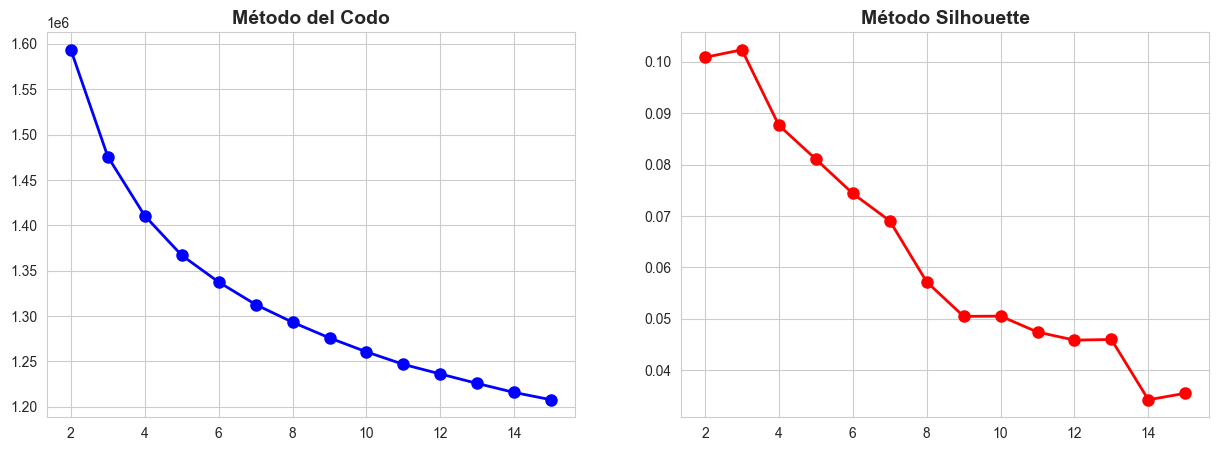


K sugerido por Silhouette: 3

EVALUACIÓN DEL CLUSTERING (k=3)
Silhouette Score: 0.1024
Davies-Bouldin Index: 2.5795
Calinski-Harabasz Score: 597.8307

Distribución de películas por cluster:
  Cluster 0: 1756 películas (30.1%)
  Cluster 1: 2090 películas (35.8%)
  Cluster 2: 1985 películas (34.0%)


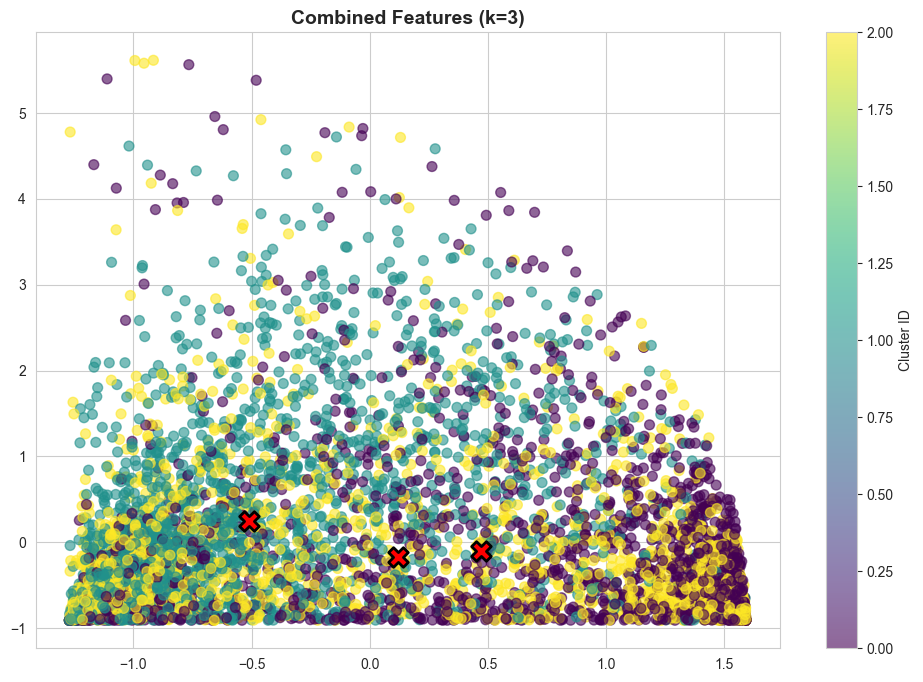

Resultados guardados en: combined_features_clustered.csv


In [8]:
results_pca = run_kmeans_analysis(df_pca, features_pca, "PCA Features")
results_umap = run_kmeans_analysis(df_umap, features_umap, "UMAP Features")
results_combined = run_kmeans_analysis(df_combined_expanded, feature_cols_combined, "Combined Features")

In [ ]:
comparison_df = pd.DataFrame({
    'Método': ['PCA', 'UMAP', 'COMBINED'],
    'K óptimo': [results_pca['k'], results_umap['k'], results_combined['k']],
    'Davies-Bouldin': [
        results_pca['metrics']['davies_bouldin'],
        results_umap['metrics']['davies_bouldin'],
        results_combined['metrics']['davies_bouldin']
    ],
    'Calinski-Harabasz': [
        results_pca['metrics']['calinski_harabasz'],
        results_umap['metrics']['calinski_harabasz'],
        results_combined['metrics']['calinski_harabasz']
    ]
})

print("COMPARACIÓN FINAL: PCA vs UMAP vs COMBINED")
print(comparison_df.to_string(index=False))
best_method = comparison_df.loc[comparison_df['Davies-Bouldin'].idxmin(), 'Método']
print(f"\nMejor método: {best_method} (menor Davies-Bouldin Index)")


##########################################################################################
COMPARACIÓN FINAL: PCA vs UMAP vs COMBINED
##########################################################################################
  Método  K óptimo  Davies-Bouldin  Calinski-Harabasz
     PCA         3        6.053270          54.160703
    UMAP         3        1.056529        3285.033481
COMBINED         3        2.579535         597.830750

🏆 Mejor método: UMAP (menor Davies-Bouldin Index)
